In [1]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ✅ Load and clean data
df = pd.read_csv('../../data/downloads/freight_model_20250423_224657.csv')
df = df.drop_duplicates(subset='invoice_id', keep='first')
df.columns

Index(['site', 'site_description', 'supplier_no', 'supplier_name',
       'invoice_id', 'account', 'account_description', 'ship_to_zip', 'po_no',
       'part_no', 'part_description', 'inv_uom', 'invoiced_line_qty',
       'est_commodity_group', 'est_method_used', 'est_standard_quantity',
       'est_standard_uom', 'est_lbs_per_uom', 'est_market_freight_costs',
       'est_total_quantity', 'est_market_rate', 'est_freight_class',
       'est_xgs_rate', 'est_rate_unit', 'est_shipment_type',
       'est_xgs_total_raw_cost', 'est_xgs_total_normalised_cost',
       'est_normalised_xgs_rate', 'est_xgs_min_applied',
       'market_cost_outlier'],
      dtype='object')

In [2]:
vnl = df[df['est_commodity_group'] == '1VNL']
cbl = df[df['est_commodity_group'] == '1CBL']

In [3]:
# Updated LBS-based simulation (e.g. 1VNL)
def simulate_ftl_thresholds_verbose(data, freight_price_col='est_market_freight_costs', quantity_col='est_total_quantity', thresholds=[5000,10000, 15000, 20000, 25000]):
    data['quantity'] = pd.to_numeric(data[quantity_col], errors='coerce')
    data['freight_price'] = pd.to_numeric(data[freight_price_col], errors='coerce')

    results = []

    for threshold in thresholds:
        data['simulated_type'] = data['quantity'].apply(lambda q: 'FTL' if q >= threshold else 'LTL')
        data['unit_cost'] = (data['freight_price'] / data['quantity']).round(2)

        grouped = data.groupby('simulated_type').agg(
            avg_cost_per_lb=('unit_cost', 'mean'),
            shipment_count=('unit_cost', 'count')
        ).reset_index()
        grouped['threshold'] = threshold
        results.append(grouped)

    combined = pd.concat(results)
    pivot = combined.pivot(index='threshold', columns='simulated_type', values=['avg_cost_per_lb', 'shipment_count']).round(3)
    pivot.columns = [f"{metric}_{stype}" for metric, stype in pivot.columns]
    return pivot.reset_index()


In [16]:
# Run simulation on 1VNL
valid_rows = vnl[(df['est_market_freight_costs'] > 0) & (df['est_total_quantity'] > 0)]
summary_df = simulate_ftl_thresholds_verbose(valid_rows)
display(summary_df)


C:\Users\nzhuw\AppData\Local\Temp/ipykernel_16632/2509507708.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_rows = vnl[(df['est_market_freight_costs'] > 0) & (df['est_total_quantity'] > 0)]


,threshold,avg_cost_per_lb_FTL,avg_cost_per_lb_LTL,shipment_count_FTL,shipment_count_LTL
0,5000,0.072,1.180,284.0,2509.0
1,10000,0.060,1.123,145.0,2648.0
2,15000,0.057,1.106,102.0,2691.0
3,20000,0.054,1.096,77.0,2716.0
4,25000,0.058,1.089,59.0,2734.0


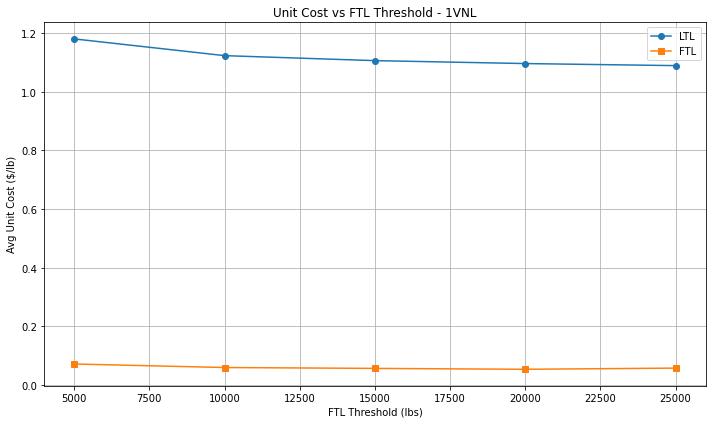

In [17]:
import matplotlib.pyplot as plt

# Example: summary_vnl or summary_cbl already generated from simulation
df = summary_df  # or summary_cbl for 1CBL

# Line plot for average cost per unit
plt.figure(figsize=(10, 6))
plt.plot(df['threshold'], df['avg_cost_per_lb_LTL'], marker='o', label='LTL')
plt.plot(df['threshold'], df['avg_cost_per_lb_FTL'], marker='s', label='FTL')

plt.title("Unit Cost vs FTL Threshold - 1VNL")
plt.xlabel("FTL Threshold (lbs)")
plt.ylabel("Avg Unit Cost ($/lb)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


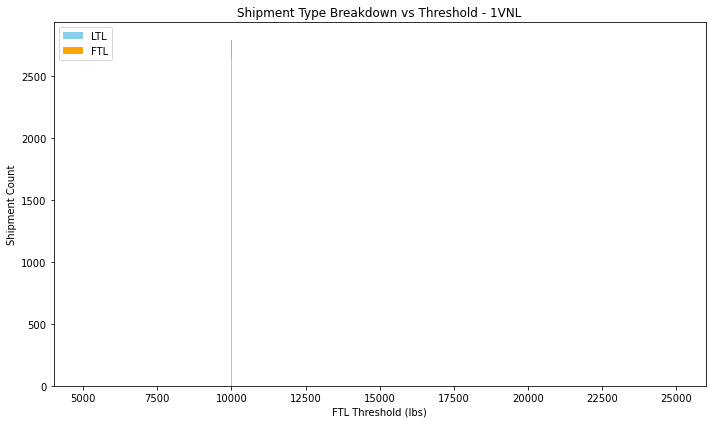

In [19]:
# Stack bar chart of shipment counts
plt.figure(figsize=(10, 6))
plt.bar(summary_df['threshold'], summary_df['shipment_count_LTL'], label='LTL', color='skyblue')
plt.bar(summary_df['threshold'], summary_df['shipment_count_FTL'], bottom=summary_df['shipment_count_LTL'], label='FTL', color='orange')

plt.title("Shipment Type Breakdown vs Threshold - 1VNL")
plt.xlabel("FTL Threshold (lbs)")
plt.ylabel("Shipment Count")
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
# Updated SQYD-based simulation (e.g. 1CBL)
def simulate_ftl_thresholds_cbl(data, freight_price_col='est_market_freight_costs', quantity_col='est_total_quantity', thresholds_in_rolls=[20, 25, 30, 45, 50, 60]):
    thresholds = [rolls * 100 for rolls in thresholds_in_rolls]

    data['quantity'] = pd.to_numeric(data[quantity_col], errors='coerce')
    data['freight_price'] = pd.to_numeric(data[freight_price_col], errors='coerce')

    results = []

    for threshold, rolls in zip(thresholds, thresholds_in_rolls):
        data['simulated_type'] = data['quantity'].apply(lambda q: 'FTL' if q >= threshold else 'LTL')
        data['unit_cost'] = (data['freight_price'] / data['quantity']).round(2)

        grouped = data.groupby('simulated_type').agg(
            avg_cost_per_sqyd=('unit_cost', 'mean'),
            shipment_count=('unit_cost', 'count')
        ).reset_index()
        grouped['threshold_rolls'] = rolls
        results.append(grouped)

    combined = pd.concat(results)
    pivot = combined.pivot(index='threshold_rolls', columns='simulated_type', values=['avg_cost_per_sqyd', 'shipment_count']).round(3)
    pivot.columns = [f"{metric}_{stype}" for metric, stype in pivot.columns]
    return pivot.reset_index()


In [6]:
# Run simulation on 1CBL
valid_rows = cbl[(cbl['est_market_freight_costs'] > 0) & (cbl['est_total_quantity'] > 0)]
summary_df = simulate_ftl_thresholds_cbl(valid_rows)
display(summary_df)


,threshold_rolls,avg_cost_per_sqyd_FTL,avg_cost_per_sqyd_LTL,shipment_count_FTL,shipment_count_LTL
0,20,0.613,1.484,22.0,482.0
1,25,0.501,1.477,16.0,488.0
2,30,0.461,1.474,14.0,490.0
3,45,0.207,1.468,9.0,495.0
4,50,0.125,1.467,8.0,496.0
5,60,0.114,1.465,7.0,497.0


In [11]:

# Prepare long-form DataFrame for cost-type comparisons
cost_columns = ['est_market_freight_costs', 'est_xgs_total_raw_cost', 'est_market_freight_costs']
df_long = df[df['est_commodity_group'] == '1CBL'].copy().melt(
    id_vars=['est_total_quantity', 'est_shipment_type'],
    value_vars=cost_columns,
    var_name='cost_type',
    value_name='cost_value'
).dropna(subset=['cost_value'])

print("df_long preview:", df_long.head())


df_long preview:    est_total_quantity est_shipment_type                 cost_type   cost_value
0              202.00               LTL  est_market_freight_costs     1.553846
1               50.00               LTL  est_market_freight_costs    68.076923
2            11457.97               FTL  est_market_freight_costs  1408.461538
3               32.00               LTL  est_market_freight_costs    26.807692
4               17.56               LTL  est_market_freight_costs   116.307692


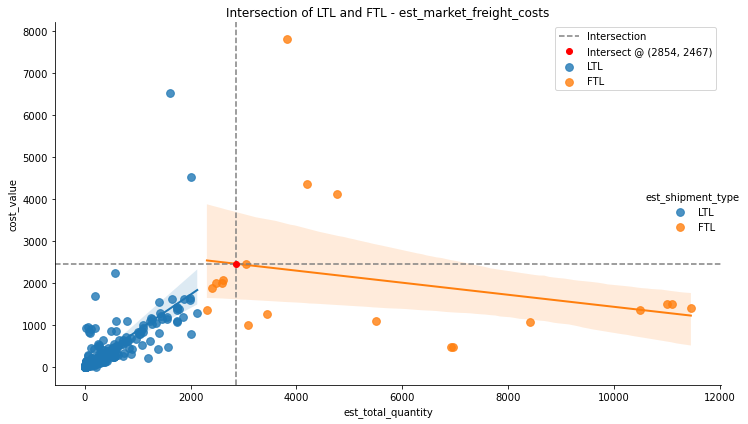

In [12]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Filter to one cost type for intersection analysis
selected_cost_type = 'est_market_freight_costs'
subset = df_long[df_long['cost_type'] == selected_cost_type]

# Fit linear regression lines for LTL and FTL
coefs = {}
for ship_type in ['LTL', 'FTL']:
    temp = subset[subset['est_shipment_type'] == ship_type]
    slope, intercept = np.polyfit(temp['est_total_quantity'], temp['cost_value'], 1)
    coefs[ship_type] = (slope, intercept)

# Compute intersection point
m1, b1 = coefs['LTL']
m2, b2 = coefs['FTL']
x_intersect = (b2 - b1) / (m1 - m2)
y_intersect = m1 * x_intersect + b1

# Plot the selected cost type with intersection point
g = sns.lmplot(
    data=subset,
    x='est_total_quantity',
    y='cost_value',
    hue='est_shipment_type',
    height=6,
    aspect=1.5,
    scatter_kws={'s': 60},
    line_kws={'linewidth': 2}
)

plt.axvline(x=x_intersect, color='gray', linestyle='--', label='Intersection')
plt.axhline(y=y_intersect, color='gray', linestyle='--')
plt.plot(x_intersect, y_intersect, 'ro', label=f'Intersect @ ({x_intersect:.0f}, {y_intersect:.0f})')
plt.title(f'Intersection of LTL and FTL - {selected_cost_type}')
plt.legend()
plt.tight_layout()
plt.show()


In [13]:

# Prepare long-form DataFrame for 1VNL (weight-based) cost-type comparisons
df_long_vnl = df[df['est_commodity_group'] == '1VNL'].copy().melt(
    id_vars=['est_total_quantity', 'est_shipment_type'],
    value_vars=['est_market_freight_costs', 'est_xgs_total_raw_cost', 'est_market_freight_costs'],
    var_name='cost_type',
    value_name='cost_value'
).dropna(subset=['cost_value'])

print("df_long_vnl preview:", df_long_vnl.head())


df_long_vnl preview:    est_total_quantity est_shipment_type                 cost_type  cost_value
0              752.62               LTL  est_market_freight_costs    4.453846
1              127.80               LTL  est_market_freight_costs    1.715385
2             4369.68               LTL  est_market_freight_costs   42.853846
3             1172.06               LTL  est_market_freight_costs   41.961538
4              208.08               LTL  est_market_freight_costs   38.115385


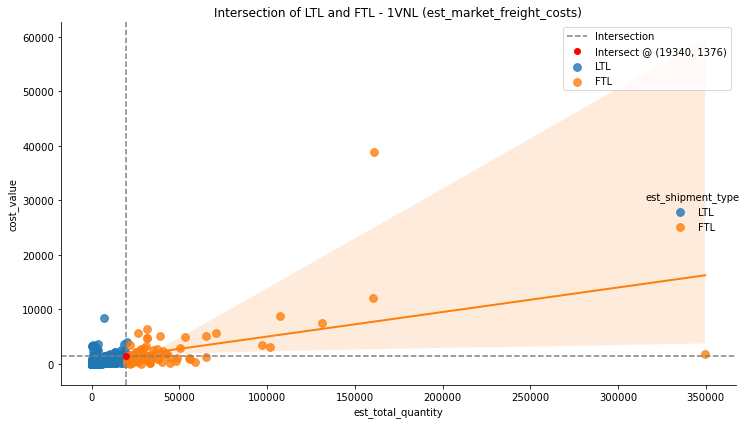

In [14]:

# Filter to one cost type for intersection analysis for 1VNL
selected_cost_type = 'est_market_freight_costs'
subset_vnl = df_long_vnl[df_long_vnl['cost_type'] == selected_cost_type]

# Fit linear regression lines for LTL and FTL
coefs = {}
for ship_type in ['LTL', 'FTL']:
    temp = subset_vnl[subset_vnl['est_shipment_type'] == ship_type]
    slope, intercept = np.polyfit(temp['est_total_quantity'], temp['cost_value'], 1)
    coefs[ship_type] = (slope, intercept)

# Compute intersection point
m1, b1 = coefs['LTL']
m2, b2 = coefs['FTL']
x_intersect = (b2 - b1) / (m1 - m2)
y_intersect = m1 * x_intersect + b1

# Plot the selected cost type with intersection point
g = sns.lmplot(
    data=subset_vnl,
    x='est_total_quantity',
    y='cost_value',
    hue='est_shipment_type',
    height=6,
    aspect=1.5,
    scatter_kws={'s': 60},
    line_kws={'linewidth': 2}
)

plt.axvline(x=x_intersect, color='gray', linestyle='--', label='Intersection')
plt.axhline(y=y_intersect, color='gray', linestyle='--')
plt.plot(x_intersect, y_intersect, 'ro', label=f'Intersect @ ({x_intersect:.0f}, {y_intersect:.0f})')
plt.title(f'Intersection of LTL and FTL - 1VNL ({selected_cost_type})')
plt.legend()
plt.tight_layout()
plt.show()
